# Stance Detection

In [47]:
import torch
import pandas as pd
import nltk
import numpy as np
import preprocessing, feature_engineering, helpers
import importlib
from collections import Counter
from sklearn.metrics import confusion_matrix
import score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import time
import itertools
import utils
import importlib
import re

In [2]:
importlib.reload(preprocessing)
importlib.reload(feature_engineering)
importlib.reload(helpers)
importlib.reload(utils)
preprocess = preprocessing.Preprocessing()

In [3]:
train_stances = pd.read_csv("fn_data/train_stances.csv")
train_stances = train_stances.loc[lambda x: x.Stance != "unrelated"]
print(train_stances.shape)
train_stances.head()

(13427, 3)


,Headline,Body ID,Stance
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
4,Spider burrowed through tourist's stomach and ...,1923,disagree
5,'Nasa Confirms Earth Will Experience 6 Days of...,154,agree
8,Banksy 'Arrested & Real Identity Revealed' Is ...,1739,agree
10,Gateway Pundit,2327,discuss


In [4]:
train_bodies = pd.read_csv("fn_data/train_bodies.csv")
print(train_bodies.shape)
train_bodies.head()

(1683, 2)


,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...


In [5]:
stances_tr, stances_val = preprocess.train_test_split(train_bodies, train_stances)
stances_tr.shape, stances_val.shape

((10684, 3), (2743, 3))

In [6]:
ct,ct2 = Counter(stances_val['Stance']),Counter(stances_tr['Stance'])
print(ct, ct2)
print(ct.most_common(1)[0][1]/len(list(stances_val["Stance"])))

Counter({'discuss': 1745, 'agree': 807, 'disagree': 191}) Counter({'discuss': 7164, 'agree': 2871, 'disagree': 649})
0.6361647830842143


In [7]:
glove_dict = preprocess.get_glove_dict("glove.6B.50d")

In [8]:
# [(nltk.pos_tag([x]),preprocess.get_sentiment(x)) for x in preprocess.get_clean_tokens(list(stances_tr.iloc[2,:])[0], False)]

In [9]:
# preprocess.cosine_similarity(glove_dict['reveal'], glove_dict['revealed'])

In [10]:
disagrees = stances_tr[stances_tr["Stance"]=="disagree"]
stances_tr = pd.concat([stances_tr, disagrees, disagrees]).sample(frac=1).reset_index(drop=True)

In [11]:
Counter(stances_tr['Stance'])

Counter({'discuss': 7164, 'disagree': 1947, 'agree': 2871})

In [12]:
def process_word_stance(word, glove_dict):
    #50d word vector
    if word in glove_dict:
        wv = glove_dict[word]
    else:
        wv = np.zeros((50, ))
    #4d sentiment
    sent = preprocess.get_sentiment(word)
    #16d one-hot encoding of part of speech (shortened)
    pos = nltk.pos_tag(word)[1][0]
    pos_encoding = [(1 if tag == pos else 0) for tag in preprocess.pos_short]
    #boolean flag for negating word
    stemmed_word = preprocess.stem_word(word)
    is_neg = (1 if stemmed_word in preprocess.negating_words_stemmed else 0)
    is_refuting = (1 if stemmed_word in preprocess.refuting_words_stemmed else 0)
    embedding = np.concatenate([wv, [sent["pos"], sent["neg"], sent["neu"], sent["compound"], is_neg, is_refuting], pos_encoding])
    return embedding

def process_text_stance(text, glove_dict, n_words = 20):
    tokens = preprocess.get_clean_tokens(text, False)
    if len(tokens)>=n_words:
        tokens = tokens[:n_words]
        encoding = np.array([process_word_stance(token, glove_dict) for token in tokens])
    elif len(tokens)<n_words:
        padding = [np.zeros((72,))]*(n_words-len(tokens))
        encoding = np.array([process_word_stance(token, glove_dict) for token in tokens]+padding)
    return encoding

def process_bodies_stance(df, glove_dict):
    body_info = {}
    ids = list(df["Body ID"])
    for i in range(len(ids)):
        if i % 100 == 0 and i != 0:
            print("processed "+str(i))
        body_info[ids[i]] = process_text_stance(preprocess.get_body(ids[i],df), glove_dict, 40)
    print("done! processed " + str(len(ids)))
    return body_info

def process_feats_stance(data, body_dict, glove_dict):
    headline, body_id = data[0], int(data[1])
    padding = [np.zeros((72,))]*(1)
    return np.concatenate([process_text_stance(headline, glove_dict), np.array(padding), body_dict[body_id]])

In [13]:
body_dict = process_bodies_stance(train_bodies, glove_dict)

processed 100
processed 200
processed 300
processed 400
processed 500
processed 600
processed 700
processed 800
processed 900
processed 1000
processed 1100
processed 1200
processed 1300
processed 1400
processed 1500
processed 1600
done! processed 1683


In [14]:
start = time.time()
train_feats = [process_feats_stance(i, body_dict, glove_dict) for i in stances_tr.values]
val_feats = [process_feats_stance(i, body_dict, glove_dict) for i in stances_val.values]
end = time.time()
print(int(end-start))

243


In [15]:
np.array(val_feats).shape

(2743, 61, 72)

In [16]:
def get_batch(data, targets, i,batch_size):
    batches = data[i*batch_size:i*batch_size+batch_size]
    results = targets[i*batch_size:i*batch_size+batch_size]
    results = [(2.0 if result == "agree" else (1.0 if result == "discuss" else 0.0)) for result in results]
    batches = np.array(batches)
    return np.swapaxes(batches, 0, 1), np.array(results)

In [17]:
# Test the Model
def eval_model(model):
    correct = 0
    total = 0
    batch_x_test,batch_y_test = get_batch(val_feats,[str(x[-1]) for x in stances_val.values],0,len(stances_val))
    model.eval()
    predicted = None
    with torch.no_grad():
        inputs = Variable(torch.FloatTensor(batch_x_test))
        labels = torch.LongTensor(batch_y_test)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    print('Accuracy: %d %%' % (100 * correct / total))
    return predicted

In [18]:
def score_model(predictions):    
    #use FNC scorer to generate score report
    label_prediction = [("agree" if x == 2 else ("discuss" if x == 1 else "disagree")) for x in predictions]
    label_actual = pd.DataFrame(stances_val)['Stance']
    matrix = confusion_matrix(label_actual,label_prediction)
    print('confusion matrix: \n{}\n'.format(matrix))
    score.report_score(label_actual, label_prediction)
    return matrix

In [19]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    correct = (preds == y).float() #convert into float for division 
    acc = correct.sum()/len(correct)
    return acc

In [20]:
# Vanilla RNN
class RNN(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.output = None
        
    def forward(self, x):
        output, hidden = self.rnn(x)
        #hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        fc = self.fc(hidden.squeeze(0))
        self.output = output
        return fc

In [21]:
# LSTM
class RNN_LSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim*2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        #x = [sent len, batch size, emb dim]
        output, (hidden, cell) = self.rnn(x)
        #output = [sent len, batch size, hid dim * num directions]
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        #hidden = [batch size, hid dim * num directions]
        fc = self.fc(hidden.squeeze(0))
        fc2 = self.fc2(F.relu(fc))
        return fc2

In [22]:
# GRU
class RNN_GRU(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        
        self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim*2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        output, hidden = self.rnn(x)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        fc = self.fc(hidden.squeeze(0))
        fc2 = self.fc2(F.relu(fc))
        return fc2

In [23]:
num_epochs = 8
batch_size = 250

EMBEDDING_DIM = 72
OUTPUT_DIM = 3
DROPOUT = 0.2
N_FILTERS = 100
FILTER_SIZE = 5

In [24]:
model1 = RNN(EMBEDDING_DIM, 128, OUTPUT_DIM, 1, DROPOUT)
opt1 = torch.optim.Adam(model1.parameters(), lr=2e-4)
m1 = model1, opt1

criterion = nn.CrossEntropyLoss()

C:\Users\linne\AppData\Local\Continuum\anaconda3\envs\cds\lib\site-packages\torch\nn\modules\rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [25]:
queue = [m1]

In [26]:
def train(model, total_batch, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for i in range(total_batch):
        batch_x,batch_y = get_batch(train_feats, [str(x[-1]) for x in stances_tr.values],i,batch_size)
        inputs = Variable(torch.FloatTensor(batch_x))
        labels = Variable(torch.LongTensor(batch_y))
        optimizer.zero_grad()
        predictions = model(inputs)
        loss = criterion(predictions, labels)
        _, predicted = torch.max(predictions.data, 1)
        acc = binary_accuracy(predicted, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / total_batch, epoch_acc / total_batch

def evaluate(model, total_batch, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for i in range(total_batch):
            batch_x,batch_y = get_batch(val_feats, [str(x[-1]) for x in stances_val.values],i,batch_size)
            inputs = Variable(torch.FloatTensor(batch_x))
            labels = Variable(torch.LongTensor(batch_y))
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            _, predicted = torch.max(predictions.data, 1)
            acc = binary_accuracy(predicted, labels)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / total_batch, epoch_acc / total_batch

In [27]:
batches_train= int(len(train_feats)/batch_size)
batches_val = int(len(val_feats)/batch_size)

for x in queue:
    model = x[0]
    optimizer = x[1]
    print("\n")
    start = time.time()
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, batches_train, optimizer, criterion)
        valid_loss, valid_acc = evaluate(model, batches_val, criterion)

        print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')
    end = time.time()
    print(int(end-start))



| Epoch: 01 | Train Loss: 0.988 | Train Acc: 54.52% | Val. Loss: 0.876 | Val. Acc: 63.56% |
| Epoch: 02 | Train Loss: 0.912 | Train Acc: 59.92% | Val. Loss: 0.861 | Val. Acc: 63.24% |
| Epoch: 03 | Train Loss: 0.872 | Train Acc: 60.83% | Val. Loss: 0.842 | Val. Acc: 63.04% |
| Epoch: 04 | Train Loss: 0.823 | Train Acc: 64.07% | Val. Loss: 0.841 | Val. Acc: 63.28% |
| Epoch: 05 | Train Loss: 0.797 | Train Acc: 65.87% | Val. Loss: 0.803 | Val. Acc: 64.68% |
| Epoch: 06 | Train Loss: 0.772 | Train Acc: 67.51% | Val. Loss: 0.808 | Val. Acc: 63.36% |
| Epoch: 07 | Train Loss: 0.754 | Train Acc: 68.43% | Val. Loss: 0.806 | Val. Acc: 63.04% |
| Epoch: 08 | Train Loss: 0.744 | Train Acc: 69.10% | Val. Loss: 0.809 | Val. Acc: 64.80% |
71


In [194]:
with torch.no_grad():
    batch_x,batch_y = get_batch(val_feats, [str(x[-1]) for x in stances_val.values],0,1)
    inputs = Variable(torch.FloatTensor(batch_x))
    labels = Variable(torch.LongTensor(batch_y))
    predictions = model(inputs)
    _, predicted = torch.max(predictions.data, 0)
output = model.output.permute([1,0,2]).squeeze(0)

In [195]:
# try comparing L2 norm for each input. This is for WHOLE hidden state
# ignore for now
"""hidden_mag = np.array([np.linalg.norm(i) for i in output])
print(scipy.stats.describe(hidden_mag))
print(hidden_mag.shape)""";

In [196]:
# looks at the activations for the specific neuron in a hidden state
# the features we'll actually compare
cell = np.array(np.swapaxes(output, 0, 1)[0])
print(scipy.stats.describe(cell))

DescribeResult(nobs=61, minmax=(-0.8246583, 0.27789927), mean=-0.35327667, variance=0.052023873, skewness=0.006424841936677694, kurtosis=0.3270336986622633)


In [197]:
def get_values(text, tokens, cell):
    wln = nltk.WordNetLemmatizer()
    j = 0 # index in tokens for duplicate token values
    num_word = 0
    body = [{} for i in range(len(text))]
        
    for i in range(len(text)):
        test = preprocess.clean(text[i])
        test = preprocess.get_tokenized_lemmas(test)
        test = preprocess.remove_stopwords(test, True)
        if(len(test)==0): 
            body[i] = {text[i]:str(0)}
            #print(text_body[i], 0)
        else:
            #token_index = np.where(tokens[j:]==test[0])
            index = list(tokens[j:]).index(test[0])
            body[i] = {text[i]:str(cell[index])}
            j+=1
    return body

In [228]:
act_cells = []
all_cells = np.array(np.swapaxes(output, 0, 1))
i = 0
for cell in all_cells:
    # Get the full headline text
    body = stances_val.iloc[0]["Body ID"]
    text_body = preprocess.get_body(body,train_bodies)
    text_headline = stances_val.iloc[0]["Headline"]

    # Get the tokens that are actually fed into the network
    tokens_body = preprocess.get_clean_tokens(text_body, False)[:40]
    tokens_headline = preprocess.get_clean_tokens(text_headline, False)[:20]
    tokens = np.concatenate((tokens_headline, tokens_body))

    text_body = text_body.split(" ")
    text_headline = text_headline.split(" ")
    text = np.concatenate((text_headline[:20], text_body[:40]))
    v = get_values(text, tokens, cell)
    values_body = v[-40:] # Gets the body text
    values_headline = v[:-40] # Gets the headline text
    values_json = {"body":values_body, "headline":values_headline,"cell_number":str(i)}
    
    i+=1
    act_cells.append(values_json)

In [229]:
import json
with open('Vis/activations.json', 'w') as outfile:  
    json.dump(values_json, outfile)
with open('Vis/activations_oneDoc_allCells.json', 'w') as outfile:
    json.dump(act_cells, outfile)
# Dump cell activations as well

In [230]:
# output = [sequence length, number of cells]
output = np.array(output)
output_cov= np.corrcoef(output, rowvar=False)
print(output_cov)

[[ 1.         -0.13556614 -0.23524899 ... -0.10311646 -0.4427335
  -0.51199404]
 [-0.13556614  1.          0.18480673 ...  0.30478905  0.02115462
   0.04370065]
 [-0.23524899  0.18480673  1.         ...  0.34280794  0.04575418
  -0.03824464]
 ...
 [-0.10311646  0.30478905  0.34280794 ...  1.         -0.19721808
  -0.10359322]
 [-0.4427335   0.02115462  0.04575418 ... -0.19721808  1.
   0.01969583]
 [-0.51199404  0.04370065 -0.03824464 ... -0.10359322  0.01969583
   1.        ]]


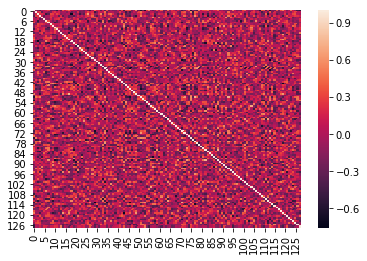

In [231]:
ax = sns.heatmap(output_cov.T)
plt.show()

In [232]:
# Cell with highest magnitude: high response overall to the whole sequence
output2_norm =[np.linalg.norm(row) for row in output.T]
output3_norm = np.argsort(output2_norm)
output_norm = np.array(output.T)[output3_norm]
output_highMag = output_norm[:5] # cells with highest mangitude

# Cell with smallest magnitude: low response
output_lowMag = output_norm[-5:] # cells with 5 lowest magnitude

# Cell with with greatest variance: 
output2_var = [np.var(row) for row in output.T]
output3_var = np.argsort(output2_var)
output_var = np.array(output.T)[output3_var]
output_highVar = output_var[:5]

# Cell with least variance
output_lowVar = output_var[-5:]

# Get all the cells that highly correlate
# Can the number of cells with high correlation tell us to decrease the hidden dim? Could be redundant info/overfitting...
np.fill_diagonal(output_cov,0)
output2_cov = np.argsort(np.triu(np.abs(output_cov)).flatten()) # take 1 triangle to avoid duplicates
cov_pairs = []
for i in range(1,6):
    #print(output2_cov[i])
    #print("output shape", output_cov.shape)
    #print("maxes",np.argmax(output_cov), np.max(output_cov))
    row = output2_cov[-i] % 128
    col = output2_cov[-i] // 128
    #print("row",row)
    #print("col",col)
    print([row,col],output_cov[row,col])
    cov_pairs.append([row,col])

[49, 17] 0.7563690953427156
[113, 29] -0.7548857647528094
[77, 51] 0.751284765702141
[88, 82] 0.7353390228572624
[18, 2] -0.7274515295875261


In [244]:
# Format for storing the cells of note for a specific sentence
cells_json = {
    "activations":act_cells,
    "top5_mag":[str(i) for i in output3_norm[:5]],
    "bot5_mag":[str(i) for i in output3_norm[-5:]],
    "top5_var":[str(i) for i in output3_var[:5]],
    "bot5_var":[str(i) for i in output3_var[-5:]],
    "top5_corr":[[str(i[0]), str(i[1])] for i in cov_pairs]
}
with open('Vis/activations_oneDoc_goodCells.json', 'w') as outfile:
    json.dump(cells_json, outfile)